# Calcul extension neige pour la limite à 0,85°C (période de référence) fichier de sortie interpolé

In [1]:
from watermark import watermark
%load_ext watermark
print(watermark())

Last updated: 2025-04-17T07:26:02.847452+00:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.17.2

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-31-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import xesmf as xe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob

/srv/conda/envs/notebook/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [3]:
%watermark --iversions

pandas    : 2.2.3
matplotlib: 3.10.0
xarray    : 2025.1.1
cartopy   : 0.24.0
numpy     : 2.0.2
watermark : 2.5.0
xesmf     : 0.8.8



## Les fonctions utilisées

In [15]:
def get_data(path_snc, path_areacella):
    ds_snc = xr.open_dataset(path_snc)
    ds_area = xr.open_dataset(path_areacella)
    return ds_snc, ds_area

def extraction_variable_and_limit(ds_snc, variable="sncbin", GSAT=0.85, month=1, lat_min=20):
    snc = (ds_snc[variable]).interp(GSAT=0.85, month=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

    if lat_min is not None:
        snc=snc.sel(lat=snc.lat>=lat_min)

    snc = snc.where(snc < 1e19, float("nan"))

    # verification si exprimé en fraction ou %
    max_val = snc.max().item()
    if max_val > 1.5:
        print(f"La variable '{variable}' est en %. Conversion en fraction.")
        snc = snc / 100

    snc = snc.clip(0, 1)
        
    return snc

def surface_calculation(snc, areacella):
    area_km2 = areacella * 1e-6
    snow_cover_km2 = (snc * area_km2).sum(dim=["lat", "lon"], skipna=True)
    return snow_cover_km2

def plot_snow_cover(snc, title="Carte couverture neigeuse"):
    plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    snc.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
    ax.coastlines()
    plt.title(title)
    plt.show()

In [64]:
path_snc = os.path.join("~/private-storage/interp_models_SW/", "BCC-CSM2-MR_SW_reprojete.nc")
path_areacella = os.path.join("/home/jovyan/private-storage/areacella_recalcule_cdo_bis/", "BCC-CSM2-MR_gridarea_hist_recalcule.nc")

ds_snc, ds_area = get_data(path_snc, path_areacella)

snc = extraction_variable_and_limit(ds_snc)

areacella = ds_area["cell_area"]
snow_cover_km2 = surface_calculation(snc, areacella)

La variable 'sncbin' est en %. Conversion en fraction.


In [65]:
ds_snc

<xarray.Dataset> Size: 87MB
Dimensions:  (GSAT: 23, month: 12, lat: 180, lon: 360, Level: 5)
Coordinates:
  * month    (month) float32 48B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * GSAT     (GSAT) float32 92B -0.5 -0.25 0.0 0.25 0.5 ... 4.25 4.5 4.75 5.0
  * Level    (Level) float32 20B 10.0 25.0 50.0 75.0 90.0
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    sncbin   (GSAT, month, lat, lon) float32 72MB ...
    Limit    (Level, month, lat, lon) float32 16MB ...
Attributes:
    regrid_method:  nearest_s2d

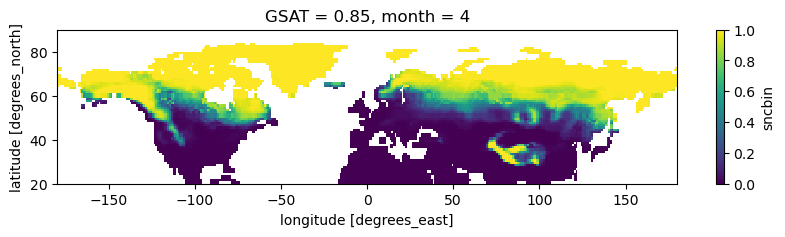

In [66]:
plt.figure(figsize=(10, 2))
snc[3].plot()

In [67]:
snow_cover_km2

<xarray.DataArray (month: 12)> Size: 96B
array([42820337.76384988, 43506155.0248663 , 40242590.01567686,
       31018373.53589035, 19273776.28027042,  9230727.14262955,
        4905885.23365045,  3883732.06741555,  5442793.28057523,
       15388071.02631272, 28036372.95260263, 37542357.92744652])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    GSAT     float64 8B 0.85

In [107]:
path_snc = os.path.join("~/private-storage/interp_models_SW/", "IPSL-CM6A-LR_SW_reprojete.nc")
path_sftgif = os.path.join("/home/jovyan/private-storage/interp_sftgif_bis/", "IPSL-CM6A-LR_sftgif_reprojete.nc")

ds_snc = xr.open_dataset(path_snc)
ds_sftgif = xr.open_dataset(path_sftgif)

sncbin = ds_snc["sncbin"]
sftgif = ds_sftgif["sftgif"]

mask = np.isnan(sncbin) | (sncbin > 1e19)

snc_combined = sncbin.where(~mask, sftgif)
#snc_combined = snc_combined.where(snc_combined != 0, np.nan)

In [108]:
sncbin

<xarray.DataArray 'sncbin' (GSAT: 23, month: 12, lat: 180, lon: 360)> Size: 72MB
array([[[[   nan, ...,    nan],
         ...,
         [   nan, ...,    nan]],

        ...,

        [[   nan, ...,    nan],
         ...,
         [   nan, ...,    nan]]],


       ...,


       [[[1.e+20, ..., 1.e+20],
         ...,
         [1.e+20, ..., 1.e+20]],

        ...,

        [[1.e+20, ..., 1.e+20],
         ...,
         [1.e+20, ..., 1.e+20]]]], dtype=float32)
Coordinates:
  * month    (month) float32 48B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * GSAT     (GSAT) float32 92B -0.5 -0.25 0.0 0.25 0.5 ... 4.25 4.5 4.75 5.0
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [109]:
snc_combined.to_netcdf("snc_combined_SW7.nc", format="NETCDF4")

In [110]:
path_snc = os.path.join("snc_combined_SW7.nc")
path_areacella = os.path.join("/home/jovyan/private-storage/areacella_recalcule_cdo_bis/", "IPSL-CM6A-LR_gridarea_hist_recalcule.nc")

ds_snc, ds_area = get_data(path_snc, path_areacella)

snc = extraction_variable_and_limit(ds_snc)

areacella = ds_area["cell_area"]
snow_cover_km2 = surface_calculation(snc, areacella)

La variable 'sncbin' est en %. Conversion en fraction.


In [111]:
snc

<xarray.DataArray 'sncbin' (month: 12, lat: 70, lon: 360)> Size: 2MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * lat      (lat) float64 560B 20.5 21.5 22.5 23.5 24.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    GSAT     float64 8B 0.85
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

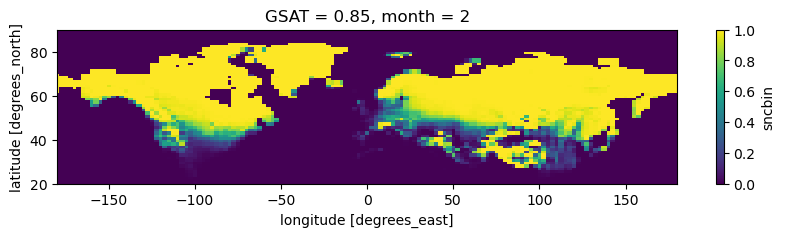

In [112]:
plt.figure(figsize=(10, 2))
snc[1].plot()

In [113]:
snc_combined

<xarray.DataArray 'sncbin' (GSAT: 23, month: 12, lat: 180, lon: 360)> Size: 72MB
array([[[[100., 100., 100., ..., 100., 100., 100.],
         [100., 100., 100., ..., 100., 100., 100.],
         [100., 100., 100., ..., 100., 100., 100.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],

        [[100., 100., 100., ..., 100., 100., 100.],
         [100., 100., 100., ..., 100., 100., 100.],
         [100., 100., 100., ..., 100., 100., 100.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],

        [[100., 100., 100., ..., 100., 100., 100.],
         [100., 100., 100., ..., 100., 100., 100.],
         [100., 100., 100., ..., 100., 100., 100.],
         ...,
...
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],

        [[100., 100., 100., ..., 100., 100., 100.],
         [100., 100., 100., ..., 100., 100., 100.],
         [100., 100., 100., ..., 100., 100., 100.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],

        [[100., 100., 100., ..., 100., 100., 100.],
         [100., 100., 100., ..., 100., 100., 100.],
         [100., 100., 100., ..., 100., 100., 100.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]]]], dtype=float32)
Coordinates:
  * month    (month) float32 48B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * GSAT     (GSAT) float32 92B -0.5 -0.25 0.0 0.25 0.5 ... 4.25 4.5 4.75 5.0
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [115]:
snow_cover_km2

<xarray.DataArray (month: 12)> Size: 96B
array([50886821.5151176 , 50036150.0643452 , 44495818.61988664,
       32545322.26440518, 16665898.2976849 ,  6696943.04838643,
        4853986.60579911,  4732359.44566073,  6274855.17977324,
       17685483.43820073, 34346024.66134053, 45957387.86591715])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    GSAT     float64 8B 0.85